In [1]:
import pandas as pd
import roner
from tqdm import tqdm
import spacy
import re
from datasets import load_dataset

In [2]:
# Load the RoNER model
ner = roner.NER()

c:\Users\stoic\miniconda3\envs\llms_env\lib\site-packages\torch\_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
2025-01-06 14:53:46 WARNING: GPU requested, but is not available!


In [3]:
# Load dataset and take random 1000 samples
dataset = load_dataset("readerbench/ro-text-summarization")
train_data = pd.DataFrame(dataset["train"])
train_data = train_data.sample(n=1000, random_state=42)

In [4]:
train_data

,Category,Title,Content,Summary,href,Source
57255,sanatate,Prima tranșă de vaccinuri Pfizer pentru copiii...,Transportul către centrele de stocare este asi...,114.000 doze de vaccin de la compania Pfizer B...,https://www.digi24.ro/stiri/actualitate/sanata...,digi24
12639,entertainment,În premieră la Digi Life: Vieți care salvează ...,Fiecare episod va fi precedat de câte un talk-...,"Digi Life va difuza în premieră, în luna decem...",https://www.digi24.ro/magazin/timp-liber/diver...,digi24
52486,guvern,"Marcel Vela, ultimatum pentru Jandarmeria Bucu...",Ministrul de interne știe cine este de vină. V...,Ministrul Marcel Vela se vede nevoit să le dea...,https://www.digi24.ro/stiri/actualitate/politi...,digi24
36424,guvern,"Ungaria și-a redeschis barurile și terasele, î...",Tot mai multe țări își încep drumul spre norma...,Barurile și terasele s-au redeschis în Ungaria...,https://alephnews.ro/guvern/ungaria-si-a-redes...,alephnews
30655,externe,Rușii fură 2.700 de tone de metal din Mariupol...,Un purtător de cuvânt al portului a declarat p...,O navă a intrat în portul ucrainean Mariupol p...,https://www.digi24.ro/stiri/externe/rusii-fura...,digi24
...,...,...,...,...,...,...
5970,sanatate,Studiu REGINA MARIA: Expunerea la virus poate ...,În cazul pacienților care s-au vaccinat și au ...,Studiul desfășurat de REGINA MARIA pentru a ur...,https://www.digi24.ro/stiri/actualitate/sanata...,digi24
31493,guvern,Proiect de lege: interzicerea organizațiilor ș...,"Potrivit inițiatorilor, proiectul ""vine să rep...",Deputații USR Cristian Ghinea și Vlad-Emanuel ...,https://www.digi24.ro/stiri/actualitate/politi...,digi24
32617,stiinta,GALERIE FOTO. Descoperire arheologică valoroas...,31069080_1758264587552517_7598345253170446336_...,Arheologii egipteni au descoperit un altar ant...,https://www.digi24.ro/stiri/sci-tech/descoperi...,digi24
29596,justitie,DIICOT face cercetări in rem în cazul accesări...,Procurorii Direcției de Investigare a Infracți...,DIICOT face cercetări in rem în cazul accesări...,https://alephnews.ro/justitie/diicot-face-cerc...,alephnews


In [5]:
# Function to clean text
def clean_text(text):
    # Remove URLs, HTML tags, and special characters
    text = re.sub(r"http\S+|www\S+|https\S+", "", text, flags=re.MULTILINE)
    text = re.sub(r"<.*?>", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower()  # Convert to lowercase
    return text

In [11]:
# Function to extract named entities
def extract_named_entities_with_metadata(text):
    entities = []
    cleaned_text = clean_text(text)  # Preprocess text
    output = ner([cleaned_text])  # Get NER output
    for word in output[0]["words"]:
        if word["tag"] != "O":  # Exclude non-entities
            entities.append({
                "text": word["text"],
                "tag": word["tag"],
                "start_char": word["start_char"],  # Use start_char instead of start_pos
                "end_char": word["end_char"],    # Use end_char instead of end_pos
                "multi_word_entity": word.get("multi_word_entity", False),  # Handle optional fields safely
                "pos": word.get("pos", None),   # Include part of speech if available
            })
    return entities

In [12]:
# Add dependency-based entity grouping (e.g., organization-people relationship)
nlp = spacy.load("ro_core_news_sm")
RELEVANT_RELATIONS = {"nsubj", "nsubj:pass", "obj", "iobj", "obl", "obl:agent", "xcomp", "ccomp"}

In [13]:
doc = nlp("Ion și Maria lucrează la Google.")
print(doc.text)
for token in doc:
    print(token.text, token.pos_, token.dep_)
    
# print all dep_ values in nlp
for dep in nlp.get_pipe("parser").labels:
    print(dep)

Ion și Maria lucrează la Google.
Ion PROPN nsubj
și CCONJ cc
Maria PROPN conj
lucrează VERB ROOT
la ADP case
Google PROPN obl
. PUNCT punct
ROOT
acl
advcl
advcl:tcl
advmod
advmod:tmod
amod
appos
aux
aux:pass
case
cc
cc:preconj
ccomp
ccomp:pmod
compound
conj
cop
csubj
csubj:pass
dep
det
expl
expl:impers
expl:pass
expl:poss
expl:pv
fixed
flat
goeswith
iobj
mark
nmod
nmod:tmod
nsubj
nsubj:pass
nummod
obj
obl
obl:agent
obl:pmod
orphan
parataxis
punct
vocative
xcomp


In [14]:
def batch_extract_dependency_relations(texts):
    all_relations = []
    docs = nlp.pipe(texts, batch_size=50)  # Process texts in batches
    for doc in docs:
        relations = []
        for token in doc:
            if token.dep_ in RELEVANT_RELATIONS:
                relations.append({
                    "head": token.head.text,
                    "dependent": token.text,
                    "relation": token.dep_,
                })
        all_relations.append(relations)
    return all_relations

In [16]:
# Process the dataset in batches
tqdm.pandas()
train_data["cleaned_content"] = train_data["Content"].progress_apply(clean_text)
train_data["relations"] = batch_extract_dependency_relations(train_data["cleaned_content"].tolist())
train_data["entities"] = train_data["cleaned_content"].progress_apply(extract_named_entities_with_metadata)

100%|██████████| 1000/1000 [17:07<00:00,  1.03s/it]


In [17]:
# Save results
train_data.to_json("NewsArticles/entities_and_relations.json", orient="records", lines=True)

In [18]:
# Save results so that romanian text can be displayed (e.g. ș, ț, ă)
train_data.to_csv("NewsArticles/entities_and_relations.csv", index=False)

In [19]:
from pyvis.network import Network
import networkx as nx
import pandas as pd

In [20]:
def build_interactive_knowledge_graph(relations, max_nodes=50):
    """
    Build an interactive knowledge graph using Pyvis.
    :param relations: List of relation dictionaries.
    :param max_nodes: Maximum number of nodes to include in the graph.
    :return: None (Saves the interactive graph as an HTML file).
    """
    G = nx.DiGraph()

    # Add nodes and edges
    for relation in relations:
        head = relation['head']
        dependent = relation['dependent']
        rel_type = relation['relation']

        G.add_edge(head, dependent, label=rel_type)

    # Filter graph to reduce node count (most connected nodes)
    if len(G.nodes) > max_nodes:
        degrees = dict(G.degree())
        top_nodes = sorted(degrees, key=degrees.get, reverse=True)[:max_nodes]
        G = G.subgraph(top_nodes)

    # Create interactive visualization with Pyvis
    net = Network(height="750px", width="100%", notebook=True, directed=True)
    net.from_nx(G)

    # Customize the graph appearance
    for node in net.nodes:
        node["size"] = G.degree[node["id"]] * 5  # Scale node size by degree

    for edge in net.edges:
        edge["title"] = edge["label"]  # Show relation type on hover
        edge["width"] = 2  # Make edges thicker

    net.set_options("""
        var options = {
          "edges": {
            "arrows": {
              "to": {
                "enabled": true
              }
            },
            "color": {
              "inherit": true
            },
            "smooth": {
              "type": "dynamic"
            }
          },
          "nodes": {
            "color": {
              "border": "#2B7CE9",
              "background": "#97C2FC"
            },
            "font": {
              "size": 12,
              "face": "Arial"
            }
          },
          "interaction": {
            "hover": true,
            "tooltipDelay": 200,
            "zoomView": true,
            "dragView": true
          },
          "physics": {
            "enabled": true,
            "stabilization": {
              "iterations": 200
            }
          }
        }
    """)

    # Save and open the interactive graph
    net.show("interactive_knowledge_graph.html")

In [21]:
# Example: Generate a knowledge graph for a single row
sample_relations = train_data['relations'].iloc[0]

if isinstance(sample_relations, str):
    sample_relations = eval(sample_relations)
    
# Build the knowledge graph
G = build_interactive_knowledge_graph(sample_relations)

interactive_knowledge_graph.html


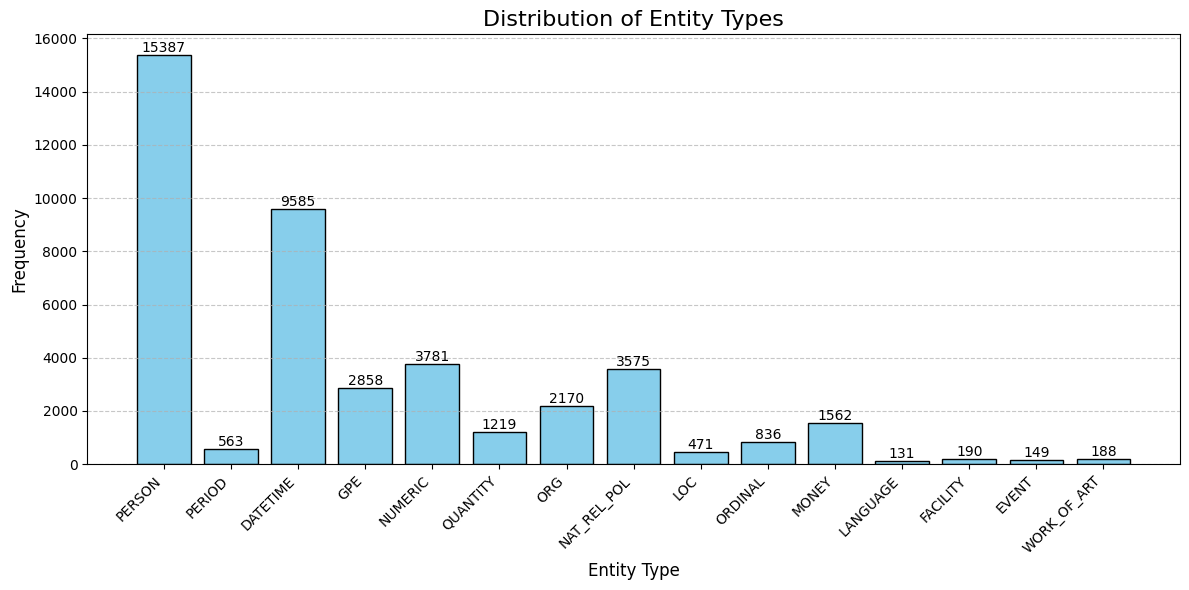

In [22]:
import matplotlib.pyplot as plt
from collections import Counter

# Process the entities to extract tags
entity_tags = []
for entities in train_data['entities']:
    if isinstance(entities, str):
        entities = eval(entities)
    entity_tags.extend([entity['tag'] for entity in entities])

# Count the tags
tag_counts = Counter(entity_tags)

# Plot distribution
plt.figure(figsize=(12, 6))
bars = plt.bar(tag_counts.keys(), tag_counts.values(), color='skyblue', edgecolor='black')

# Annotate bar values
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, height, str(height), ha='center', va='bottom', fontsize=10)

plt.title("Distribution of Entity Types", fontsize=16)
plt.xlabel("Entity Type", fontsize=12)
plt.ylabel("Frequency", fontsize=12)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [23]:
from spacy import displacy

# Highlight entities in a sample text
sample_text = clean_text(train_data['Content'].iloc[0])

# Ensure entities are in the correct format
sample_entities = train_data['entities'].iloc[0]
if isinstance(sample_entities, str):  # If it's a string, evaluate it
    sample_entities = eval(sample_entities)

# Prepare Spacy-compatible format
doc_data = {
    "text": sample_text,
    "ents": [{"start": ent["start_char"], "end": ent["end_char"], "label": ent["tag"]} for ent in sample_entities],
    "title": "Named Entities",
}

# Render
displacy.render(doc_data, style="ent", manual=True, jupyter=True)